In [1]:
import pandas as pd
import scanpy as sc
import anndata
import scanorama
import scipy.sparse as ss
import matplotlib.pyplot as plt
import seaborn as sns
from ALLCools.plot import *
import pathlib
from cemba_data.tools.integration.utilities import calculate_direct_confusion

%matplotlib inline

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Parameters

In [2]:
mc_adata_path = 'Markers/mc.cluster_markers.h5ad'
rna_adata_path = 'Markers/rna.cluster_markers.h5ad'

# scanorama
scanorama_dim = 30
sigma = 100
alpha = 0
knn = 20

# clustering
k = 30
n_pcs = 20
n_jobs=40

In [3]:
# Parameters
scanorama_dim = 30
sigma = 100
alpha = 0
knn = 20
k = 30
n_pcs = 12
n_jobs = 40


In [4]:
output_dir = 'Integration'
output_dir = pathlib.Path(output_dir)
output_dir.mkdir(exist_ok=True)

## Load Data

### mC

In [5]:
mc_adata = anndata.read_h5ad(mc_adata_path)
mc_cell_tidy_data = mc_adata.obs.copy()

In [6]:
mc_adata

AnnData object with n_obs × n_vars = 17015 × 2592 
    obs: 'AllcPath', 'CCC_Rate', 'CG_Rate', 'CG_RateAdj', 'CH_Rate', 'CH_RateAdj', 'FinalReads', 'InputReads', 'MappedReads', 'Region', 'index_name', 'uid', 'BamFilteringRate', 'MappingRate', 'Pos96', 'Plate', 'Col96', 'Row96', 'Col384', 'Row384', 'FACS_Date', 'Slice', 'CellClass', 'l1-umap_0', 'l1-umap_1', 'l1-tsne_0', 'l1-tsne_1', 'MajorType', 'l2-umap_0', 'l2-umap_1', 'l2-tsne_0', 'l2-tsne_1', 'SubType', 'l3-umap_0', 'l3-umap_1', 'l3-tsne_0', 'l3-tsne_1', 'L1CellClass', 'class_tsne_0', 'class_tsne_1', 'class_umap_0', 'class_umap_1', 'Order', 'RegionName', 'MajorRegion', 'SubRegion', 'DetailRegion', 'PotentialOverlap (MMB)', 'Anterior (CCF coords)', 'Posterior (CCF coords)', 'MajorRegionColor', 'SubRegionColor', 'DissectionRegionColor'
    var: 'chrom', 'start', 'end'

### RNA 

In [7]:
rna_adata = anndata.read_h5ad(rna_adata_path)
rna_cell_tidy_data = rna_adata.obs.copy()
rna_adata

AnnData object with n_obs × n_vars = 8960 × 422 
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascular', 'Class

## Preprocess

### Syncornize name

In [8]:
mc_adata_names = mc_adata.var_names.map(lambda i: i.split('.')[0])
judge = (mc_adata_names != '') & (~mc_adata_names.duplicated())
mc_adata = mc_adata[:, judge].copy()
mc_adata.var_names = mc_adata_names[judge]

### Union

In [9]:
union = rna_adata.var_names & mc_adata.var_names

In [10]:
print(union.size, 'genes in common')

121 genes in common


### RNA scale

In [11]:
rna_adata = rna_adata[:, union].copy()
sc.pp.scale(rna_adata)

### Reverse mC and scale

In [12]:
mc_adata = mc_adata[:, union].copy()
mc_adata.X = mc_adata.X.max() - mc_adata.X
sc.pp.scale(mc_adata)

## Integration

In [13]:
import scanorama
results = scanorama.correct_scanpy([mc_adata, rna_adata],
                                   metric='angular',
                                   dimred=scanorama_dim,
                                   sigma=sigma,
                                   alpha=alpha,
                                   knn=knn)
mc_adata, rna_adata = results

Found 121 genes among all datasets
[[0.         0.66863839]
 [0.         0.        ]]
Processing datasets (0, 1)


In [14]:
mc_adata.obs['Modality'] = 'mC'
rna_adata.obs['Modality'] = 'RNA'

In [15]:
adata = anndata.AnnData(X=ss.vstack([mc_adata.X, rna_adata.X]),
                       obs=pd.DataFrame([], index=pd.Index(mc_adata.obs_names.tolist() \
                                                           + rna_adata.obs_names.tolist())),
                       var=pd.DataFrame([], index=union))
adata.obs['Modality'] = mc_adata.obs['Modality'].tolist(
) + rna_adata.obs['Modality'].tolist()

## Clustering Routine

In [16]:
sc.tl.pca(adata)

... storing 'Modality' as categorical


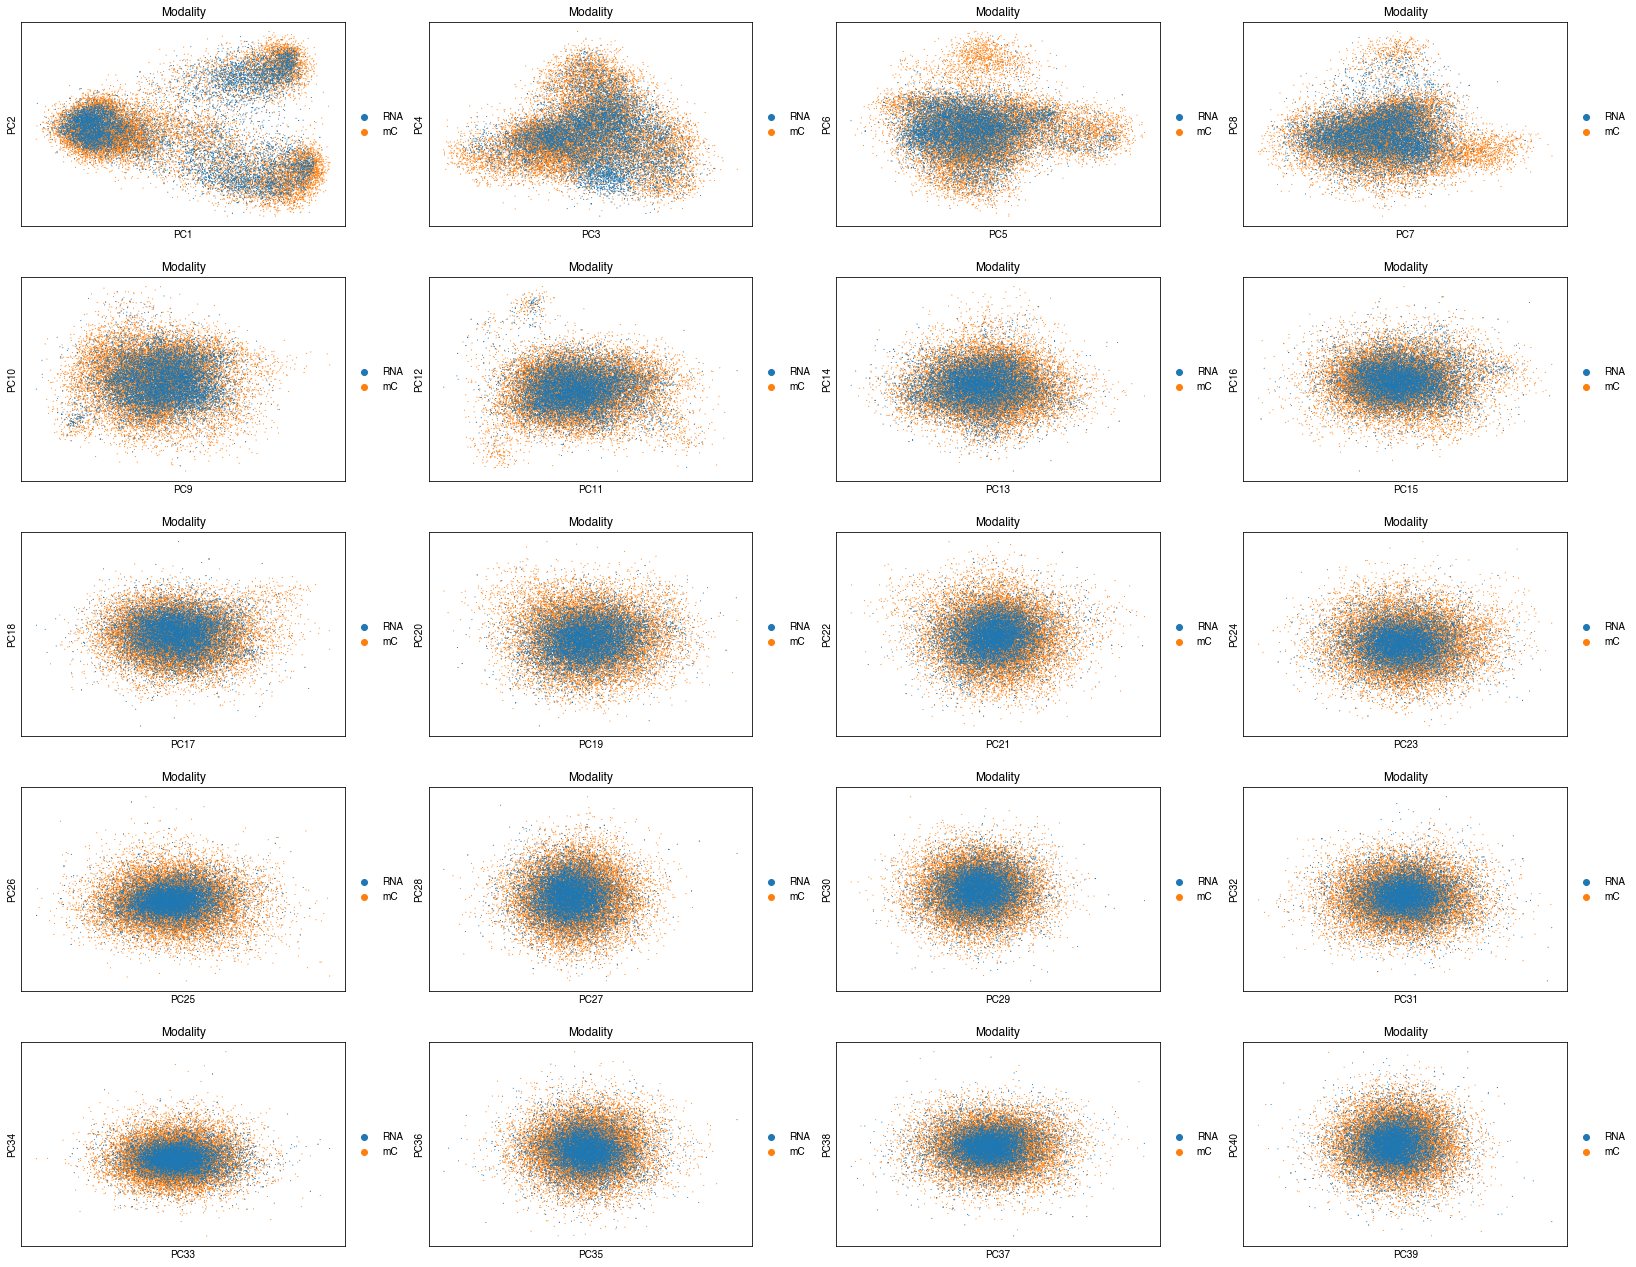

In [17]:
sc.pl.pca(adata,
          components=[
              '1,2', '3,4', '5,6', '7,8', '9,10', '11,12', '13,14', '15,16',
              '17,18', '19,20', '21,22', '23,24', '25,26', '27,28', '29,30',
              '31,32', '33, 34', '35, 36', '37, 38', '39, 40'
          ],
          color='Modality')

In [18]:
sc.pp.neighbors(adata, n_neighbors=k, n_pcs=n_pcs)
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.tl.tsne(adata, n_jobs=n_jobs)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../../../miniconda3/envs/clustering/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive

In [19]:
records = [adata.obs]
for coord in ['umap', 'pca', 'tsne']:
    temp_df = pd.DataFrame(adata.obsm[f'X_{coord}'][:, :2],
                           index=adata.obs_names,
                           columns=[f'{coord}_0', f'{coord}_1'])
    mc_cell_tidy_data[f'agg{coord}_0'] = pd.Series(
        adata.obsm[f'X_{coord}'][:, 0], index=adata.obs_names)
    mc_cell_tidy_data[f'agg{coord}_1'] = pd.Series(
        adata.obsm[f'X_{coord}'][:, 1], index=adata.obs_names)
    rna_cell_tidy_data[f'agg{coord}_0'] = pd.Series(
        adata.obsm[f'X_{coord}'][:, 0], index=adata.obs_names)
    rna_cell_tidy_data[f'agg{coord}_1'] = pd.Series(
        adata.obsm[f'X_{coord}'][:, 1], index=adata.obs_names)
    records.append(temp_df)
cell_tidy_data = pd.concat(records, axis=1)

In [20]:
mc_cell_tidy_data['co_cluster'] = pd.Series(adata.obs['leiden'],
                                            index=adata.obs_names)
rna_cell_tidy_data['co_cluster'] = pd.Series(adata.obs['leiden'],
                                             index=adata.obs_names)

## plot

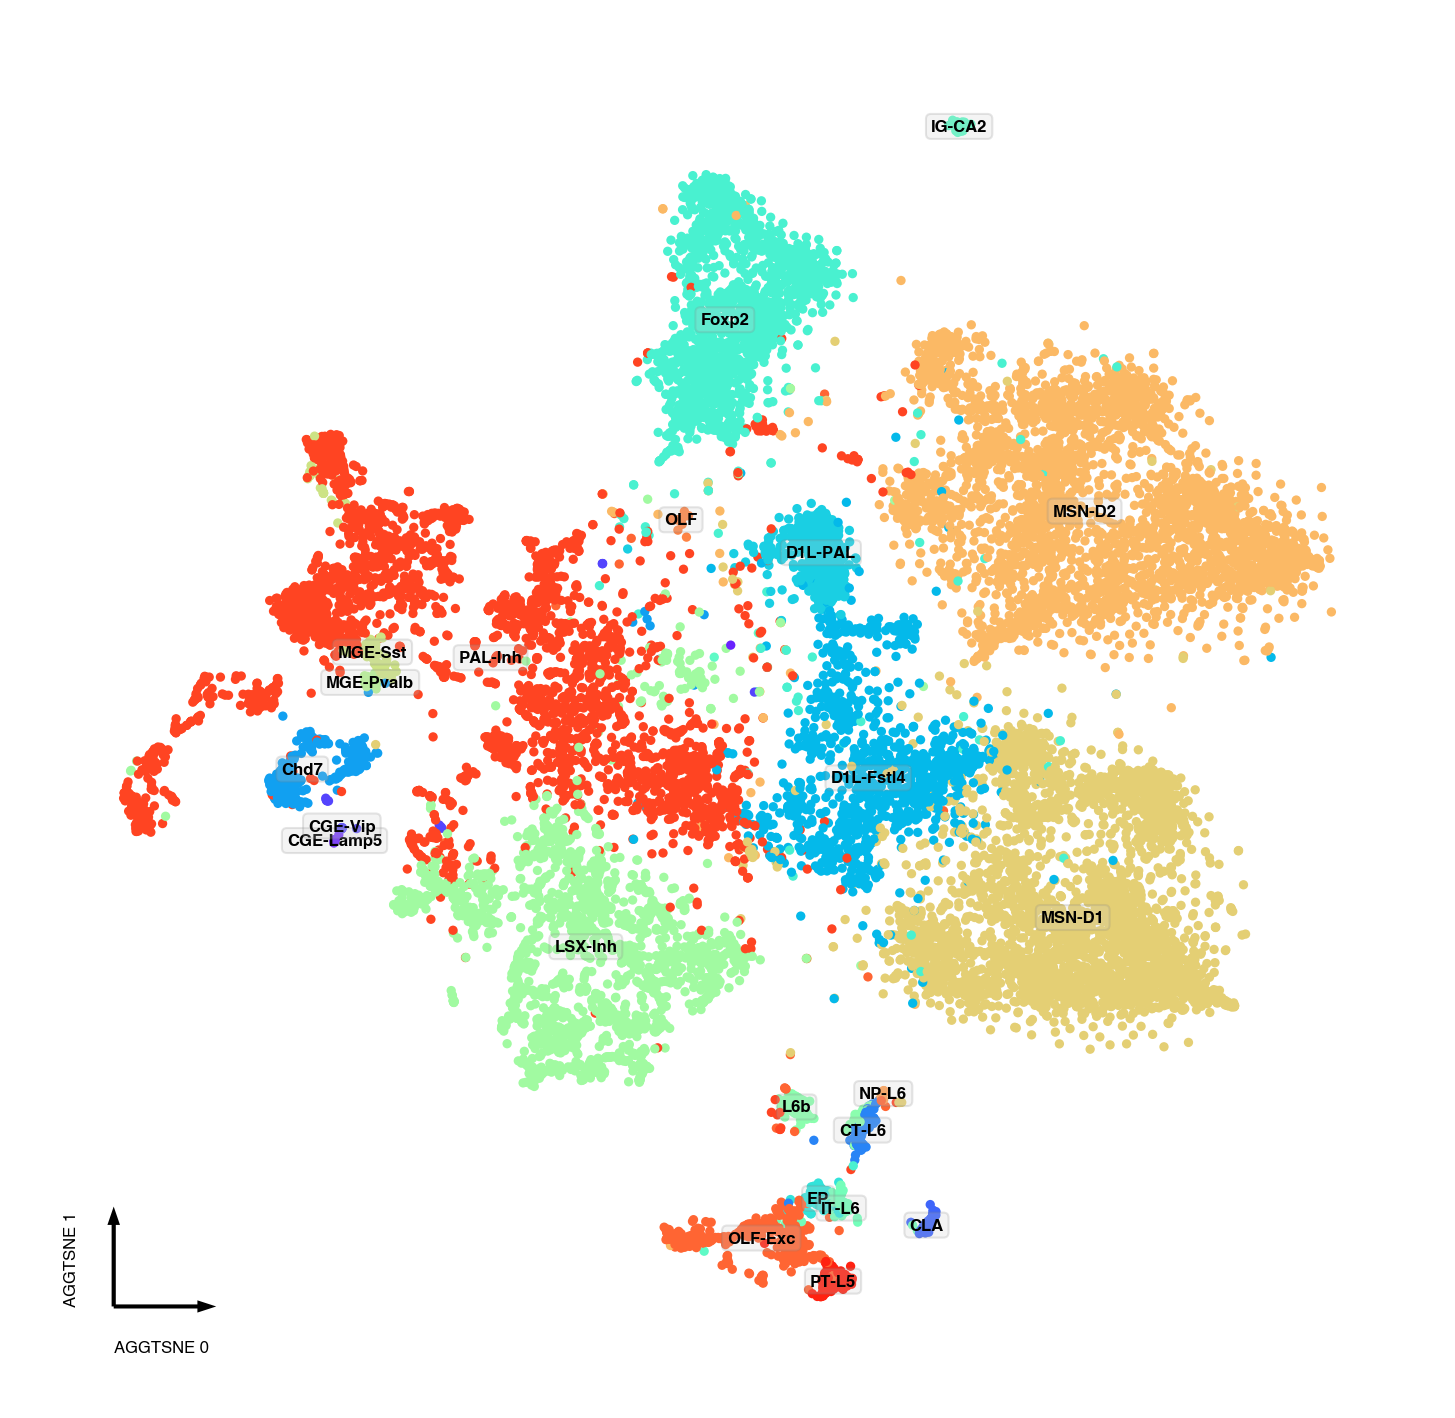

In [21]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

categorical_scatter(ax=ax,
                    data=mc_cell_tidy_data,
                    hue='MajorType',
                    coord_base='aggtsne',
                    max_points=None,
                    scatter_kws=dict(s=5),
                    text_anno='MajorType',
                    text_anno_kws=dict(fontsize=4))
pass

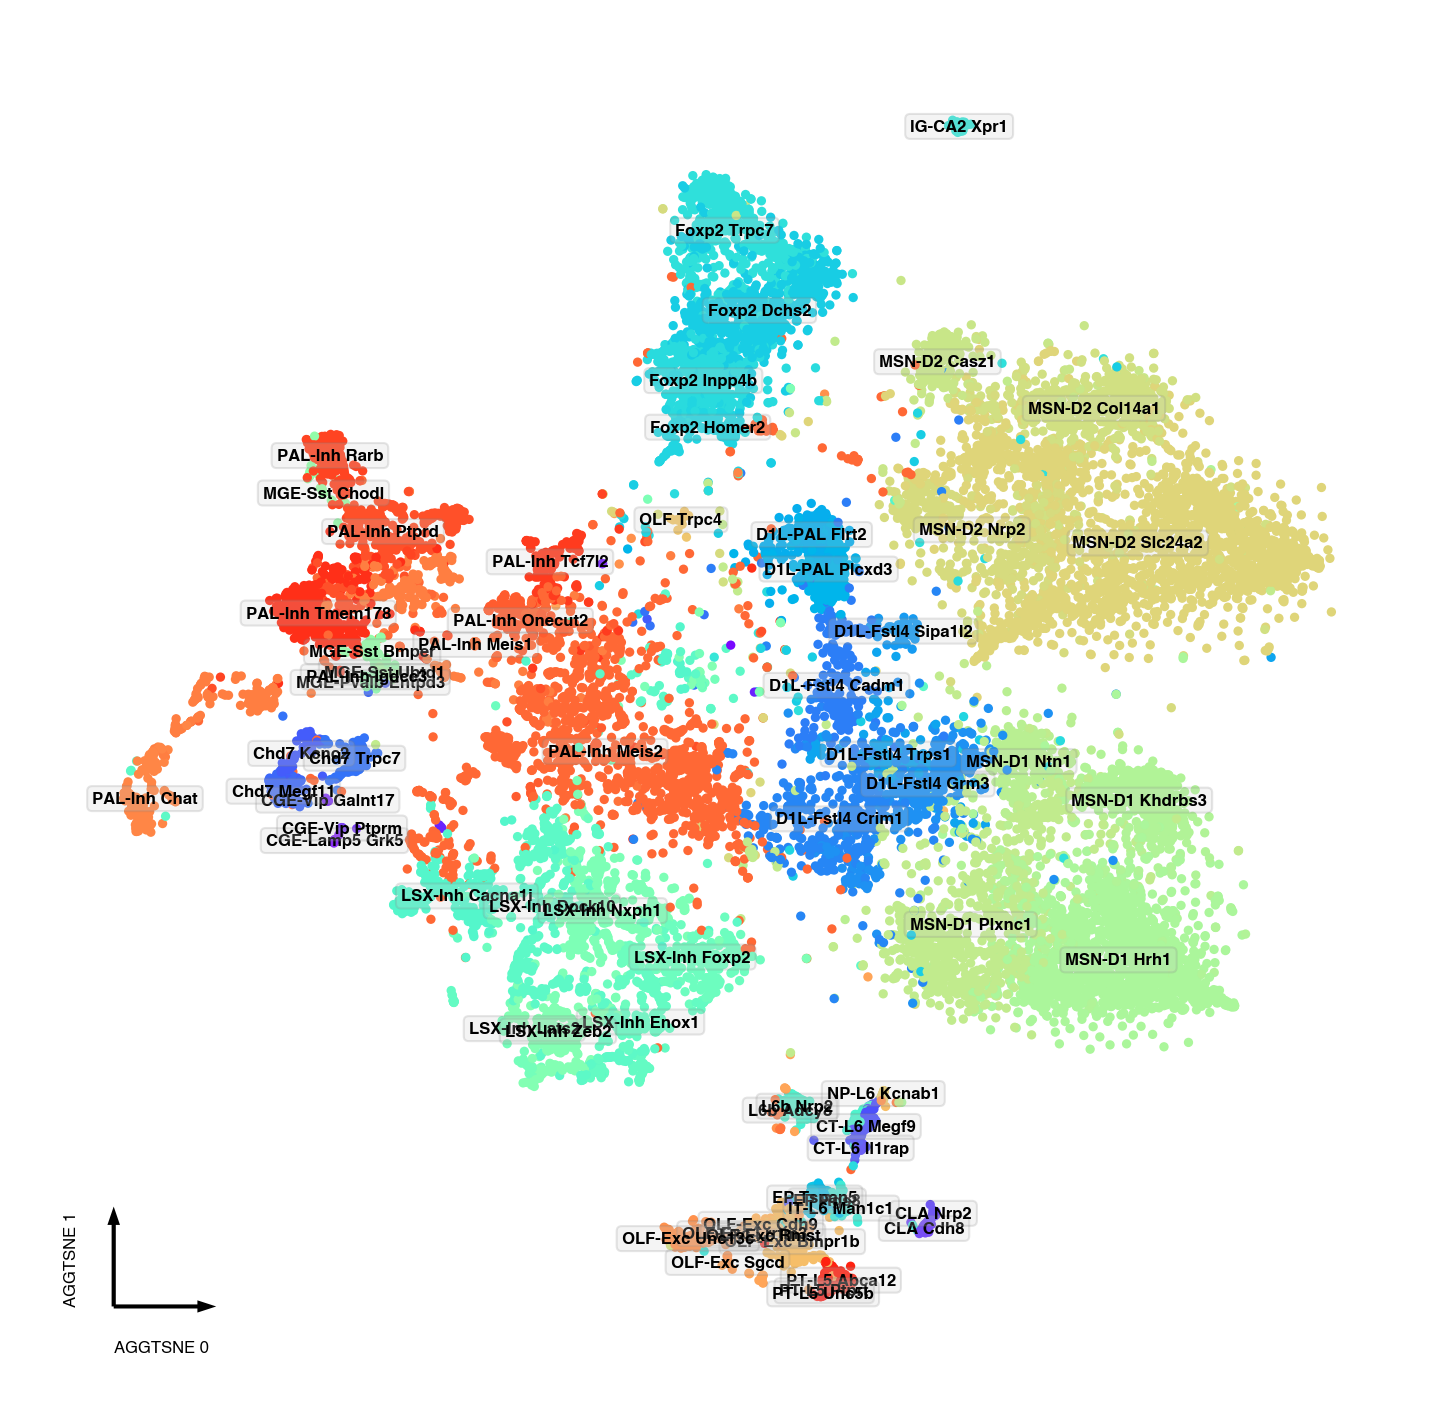

In [22]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

categorical_scatter(ax=ax,
                    data=mc_cell_tidy_data,
                    hue='SubType',
                    coord_base='aggtsne',
                    max_points=None,
                    scatter_kws=dict(s=5),
                    text_anno='SubType',
                    text_anno_kws=dict(fontsize=4))
pass

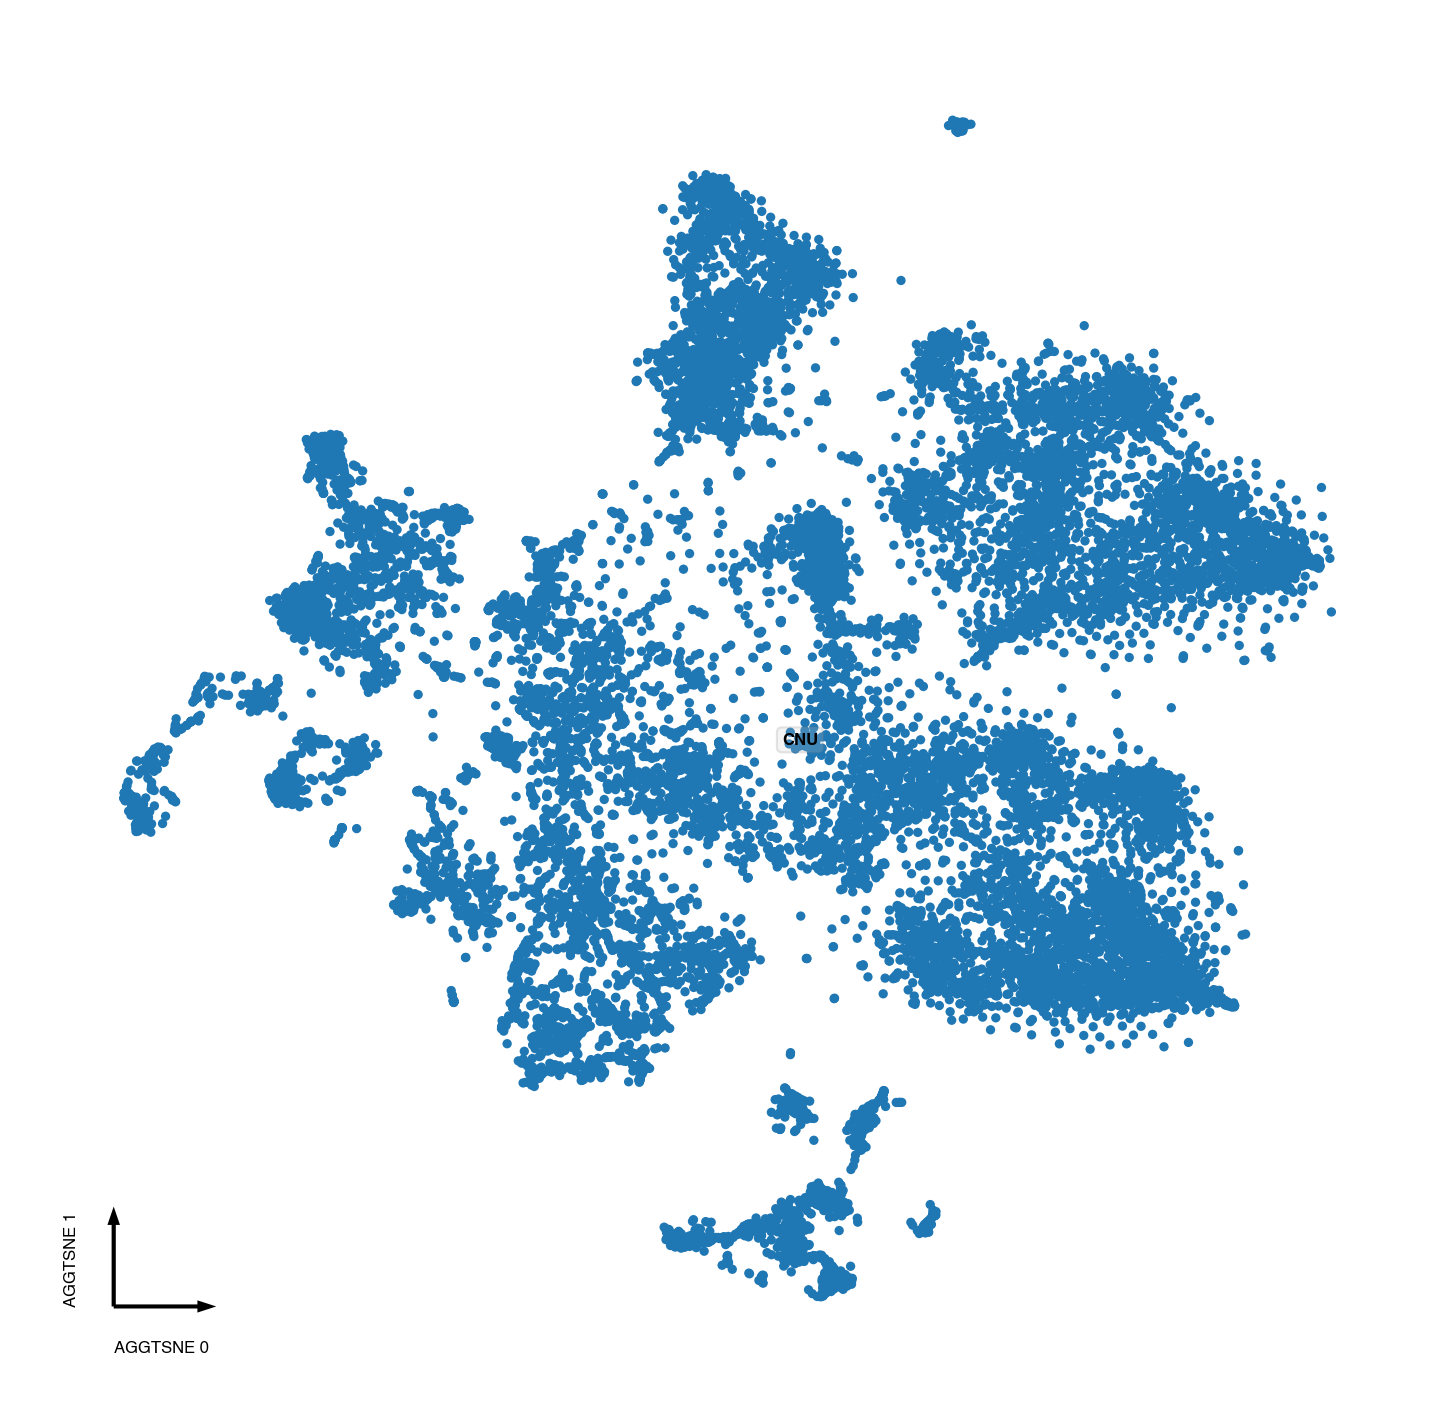

In [35]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

categorical_scatter(ax=ax,
                    data=mc_cell_tidy_data,
                    hue='MajorRegion',
                    coord_base='aggtsne',
                    max_points=None,
                    scatter_kws=dict(s=5),
                    text_anno='MajorRegion',
                    text_anno_kws=dict(fontsize=4))
pass

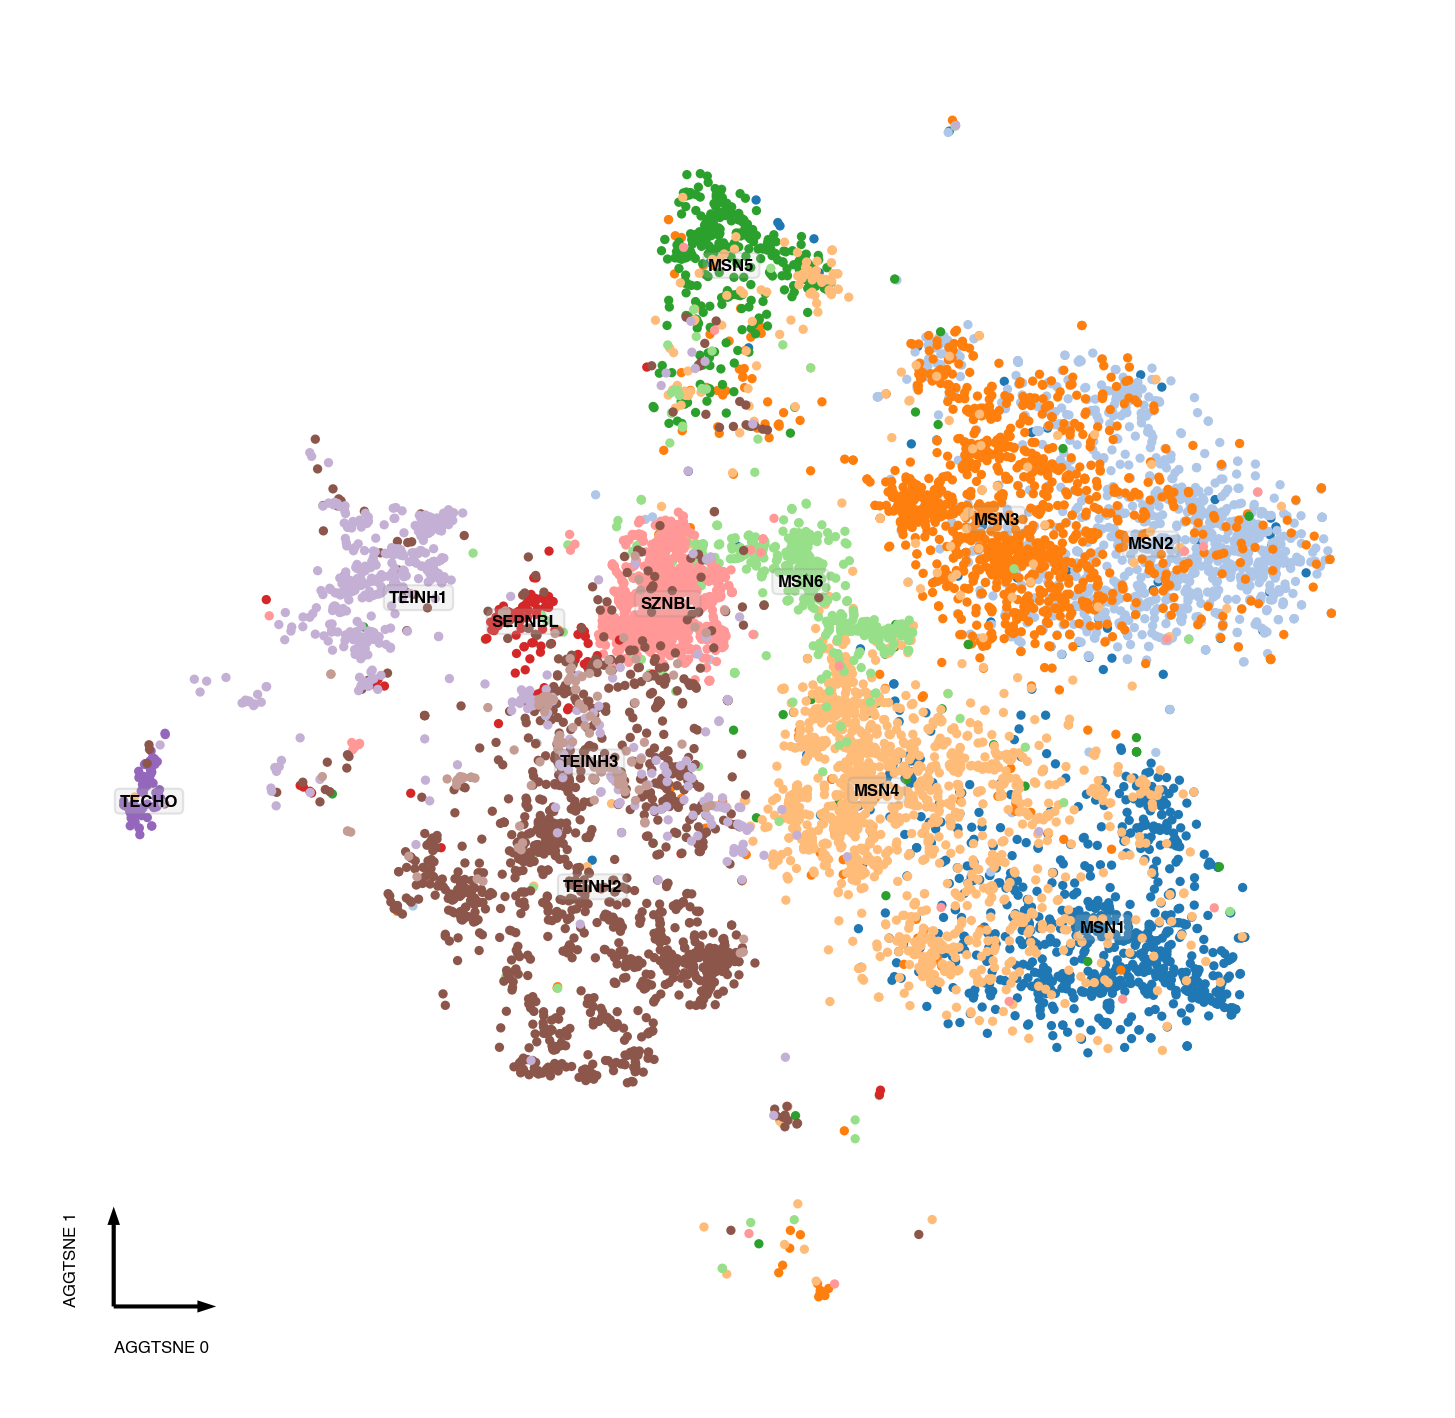

In [25]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

categorical_scatter(ax=ax,
                    data=rna_cell_tidy_data,
                    hue='SubType',
                    coord_base='aggtsne',
                    max_points=None,
                    scatter_kws=dict(s=5),
                    text_anno='SubType',
                    text_anno_kws=dict(fontsize=4))
pass

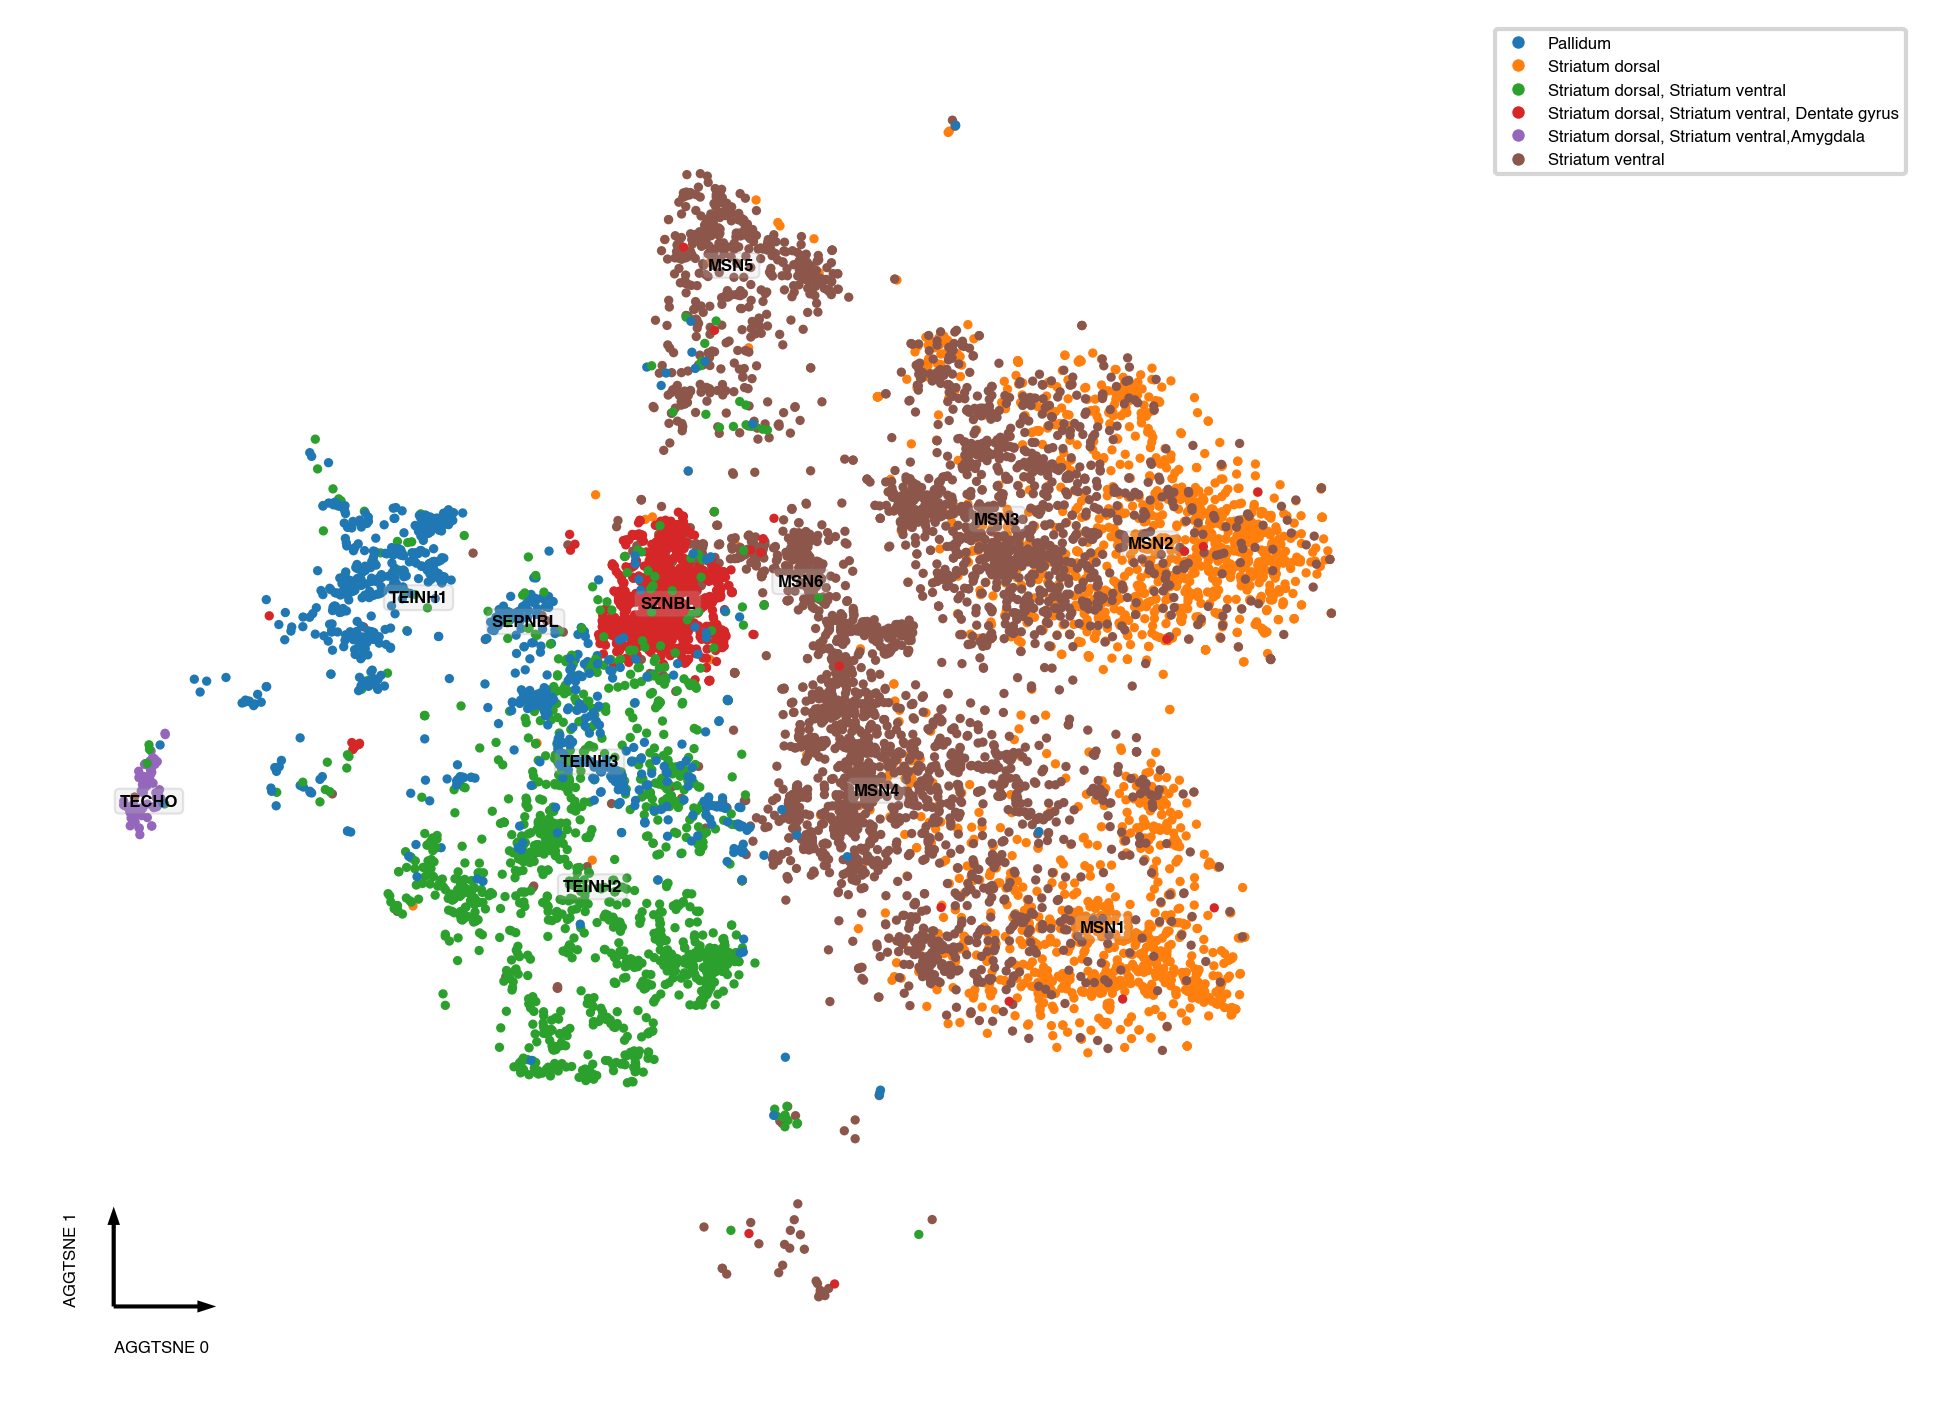

In [27]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

categorical_scatter(ax=ax,
                    data=rna_cell_tidy_data,
                    hue='Region',
                    coord_base='aggtsne',
                    max_points=None,
                    scatter_kws=dict(s=5),
                    text_anno='SubType',
                    text_anno_kws=dict(fontsize=4), 
                   show_legend=True)
pass

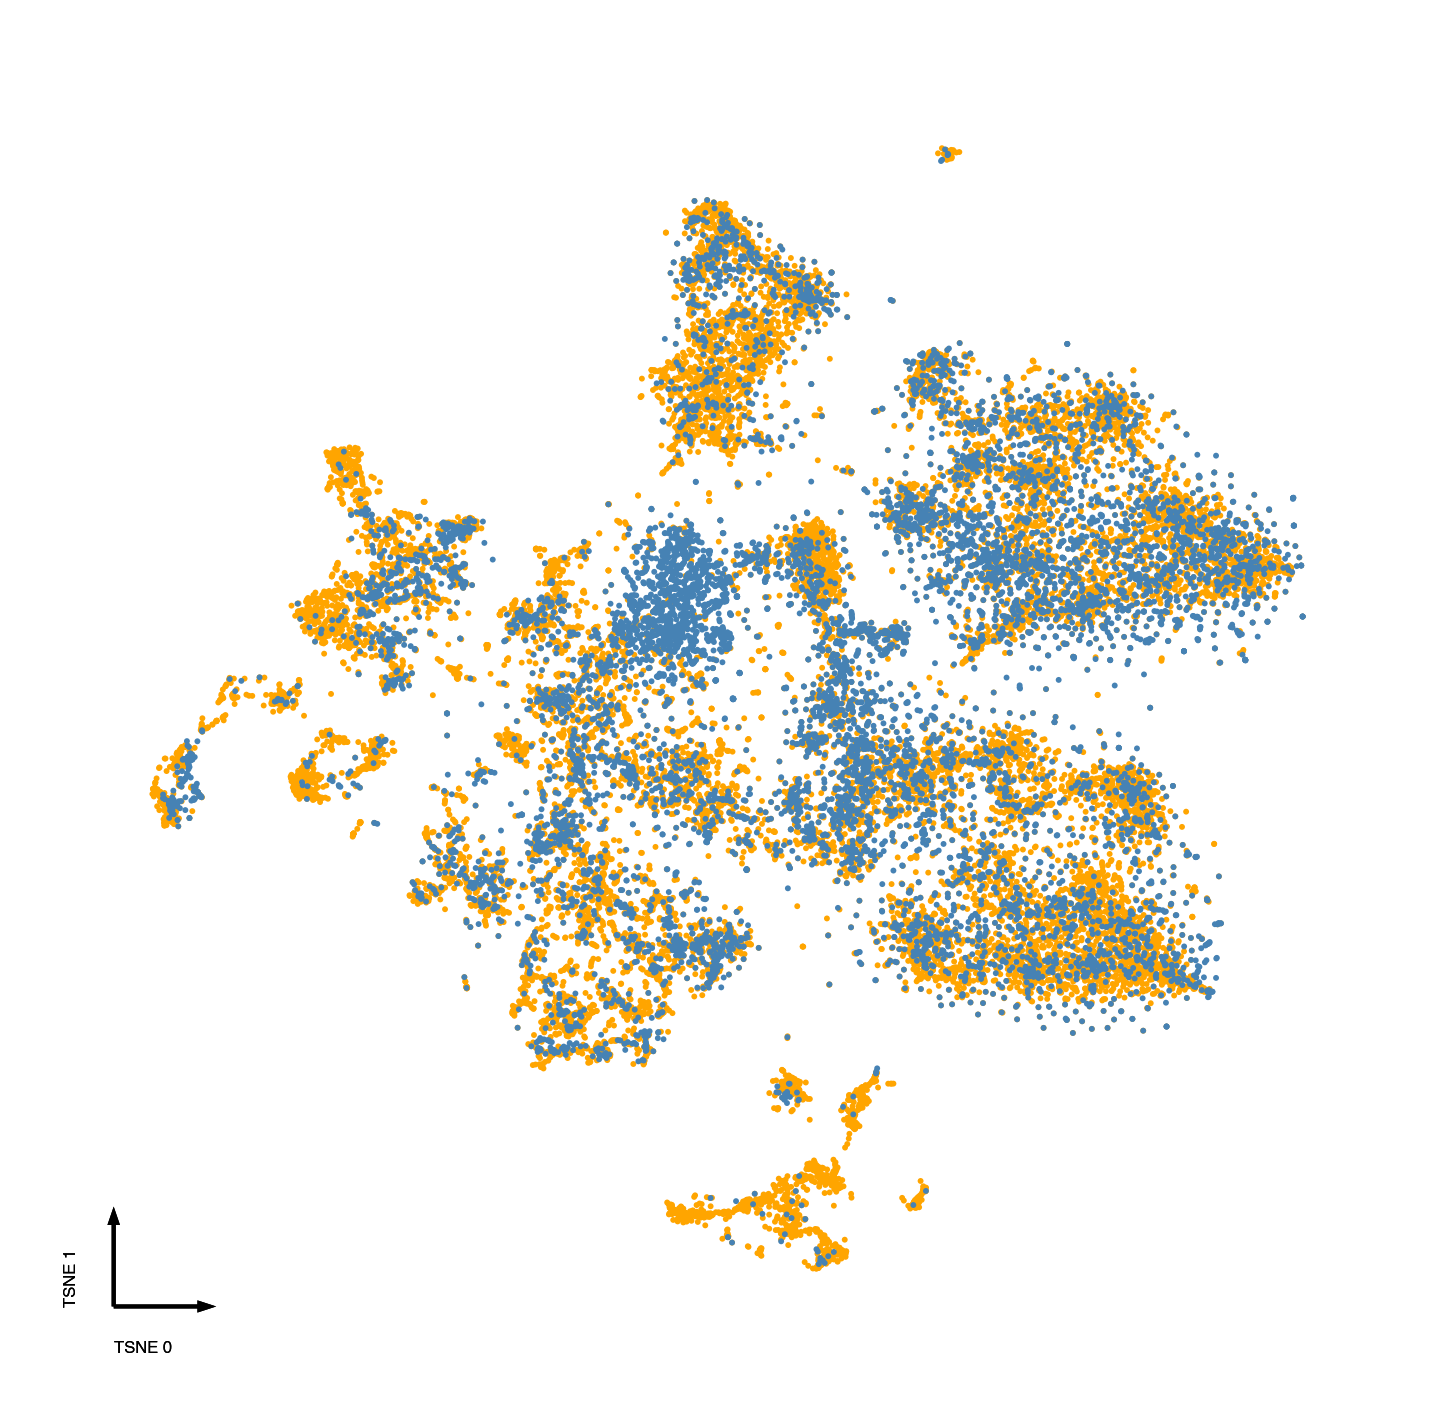

In [37]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

categorical_scatter(ax=ax,
                    data=cell_tidy_data[cell_tidy_data['Modality'] == 'mC'],
                    scatter_kws=dict(color='orange'),
                    coord_base='tsne',
                    max_points=None,
                    s=2)
categorical_scatter(ax=ax,
                    data=cell_tidy_data[cell_tidy_data['Modality'] == 'RNA'],
                    scatter_kws=dict(color='steelblue'),
                    coord_base='tsne',
                    max_points=None,
                    s=2)
pass

## Confusion matrix

In [29]:
cfm = calculate_direct_confusion(mc_cell_tidy_data[['SubType', 'co_cluster']], 
                                 rna_cell_tidy_data[['SubType', 'co_cluster']])

(0, 66)

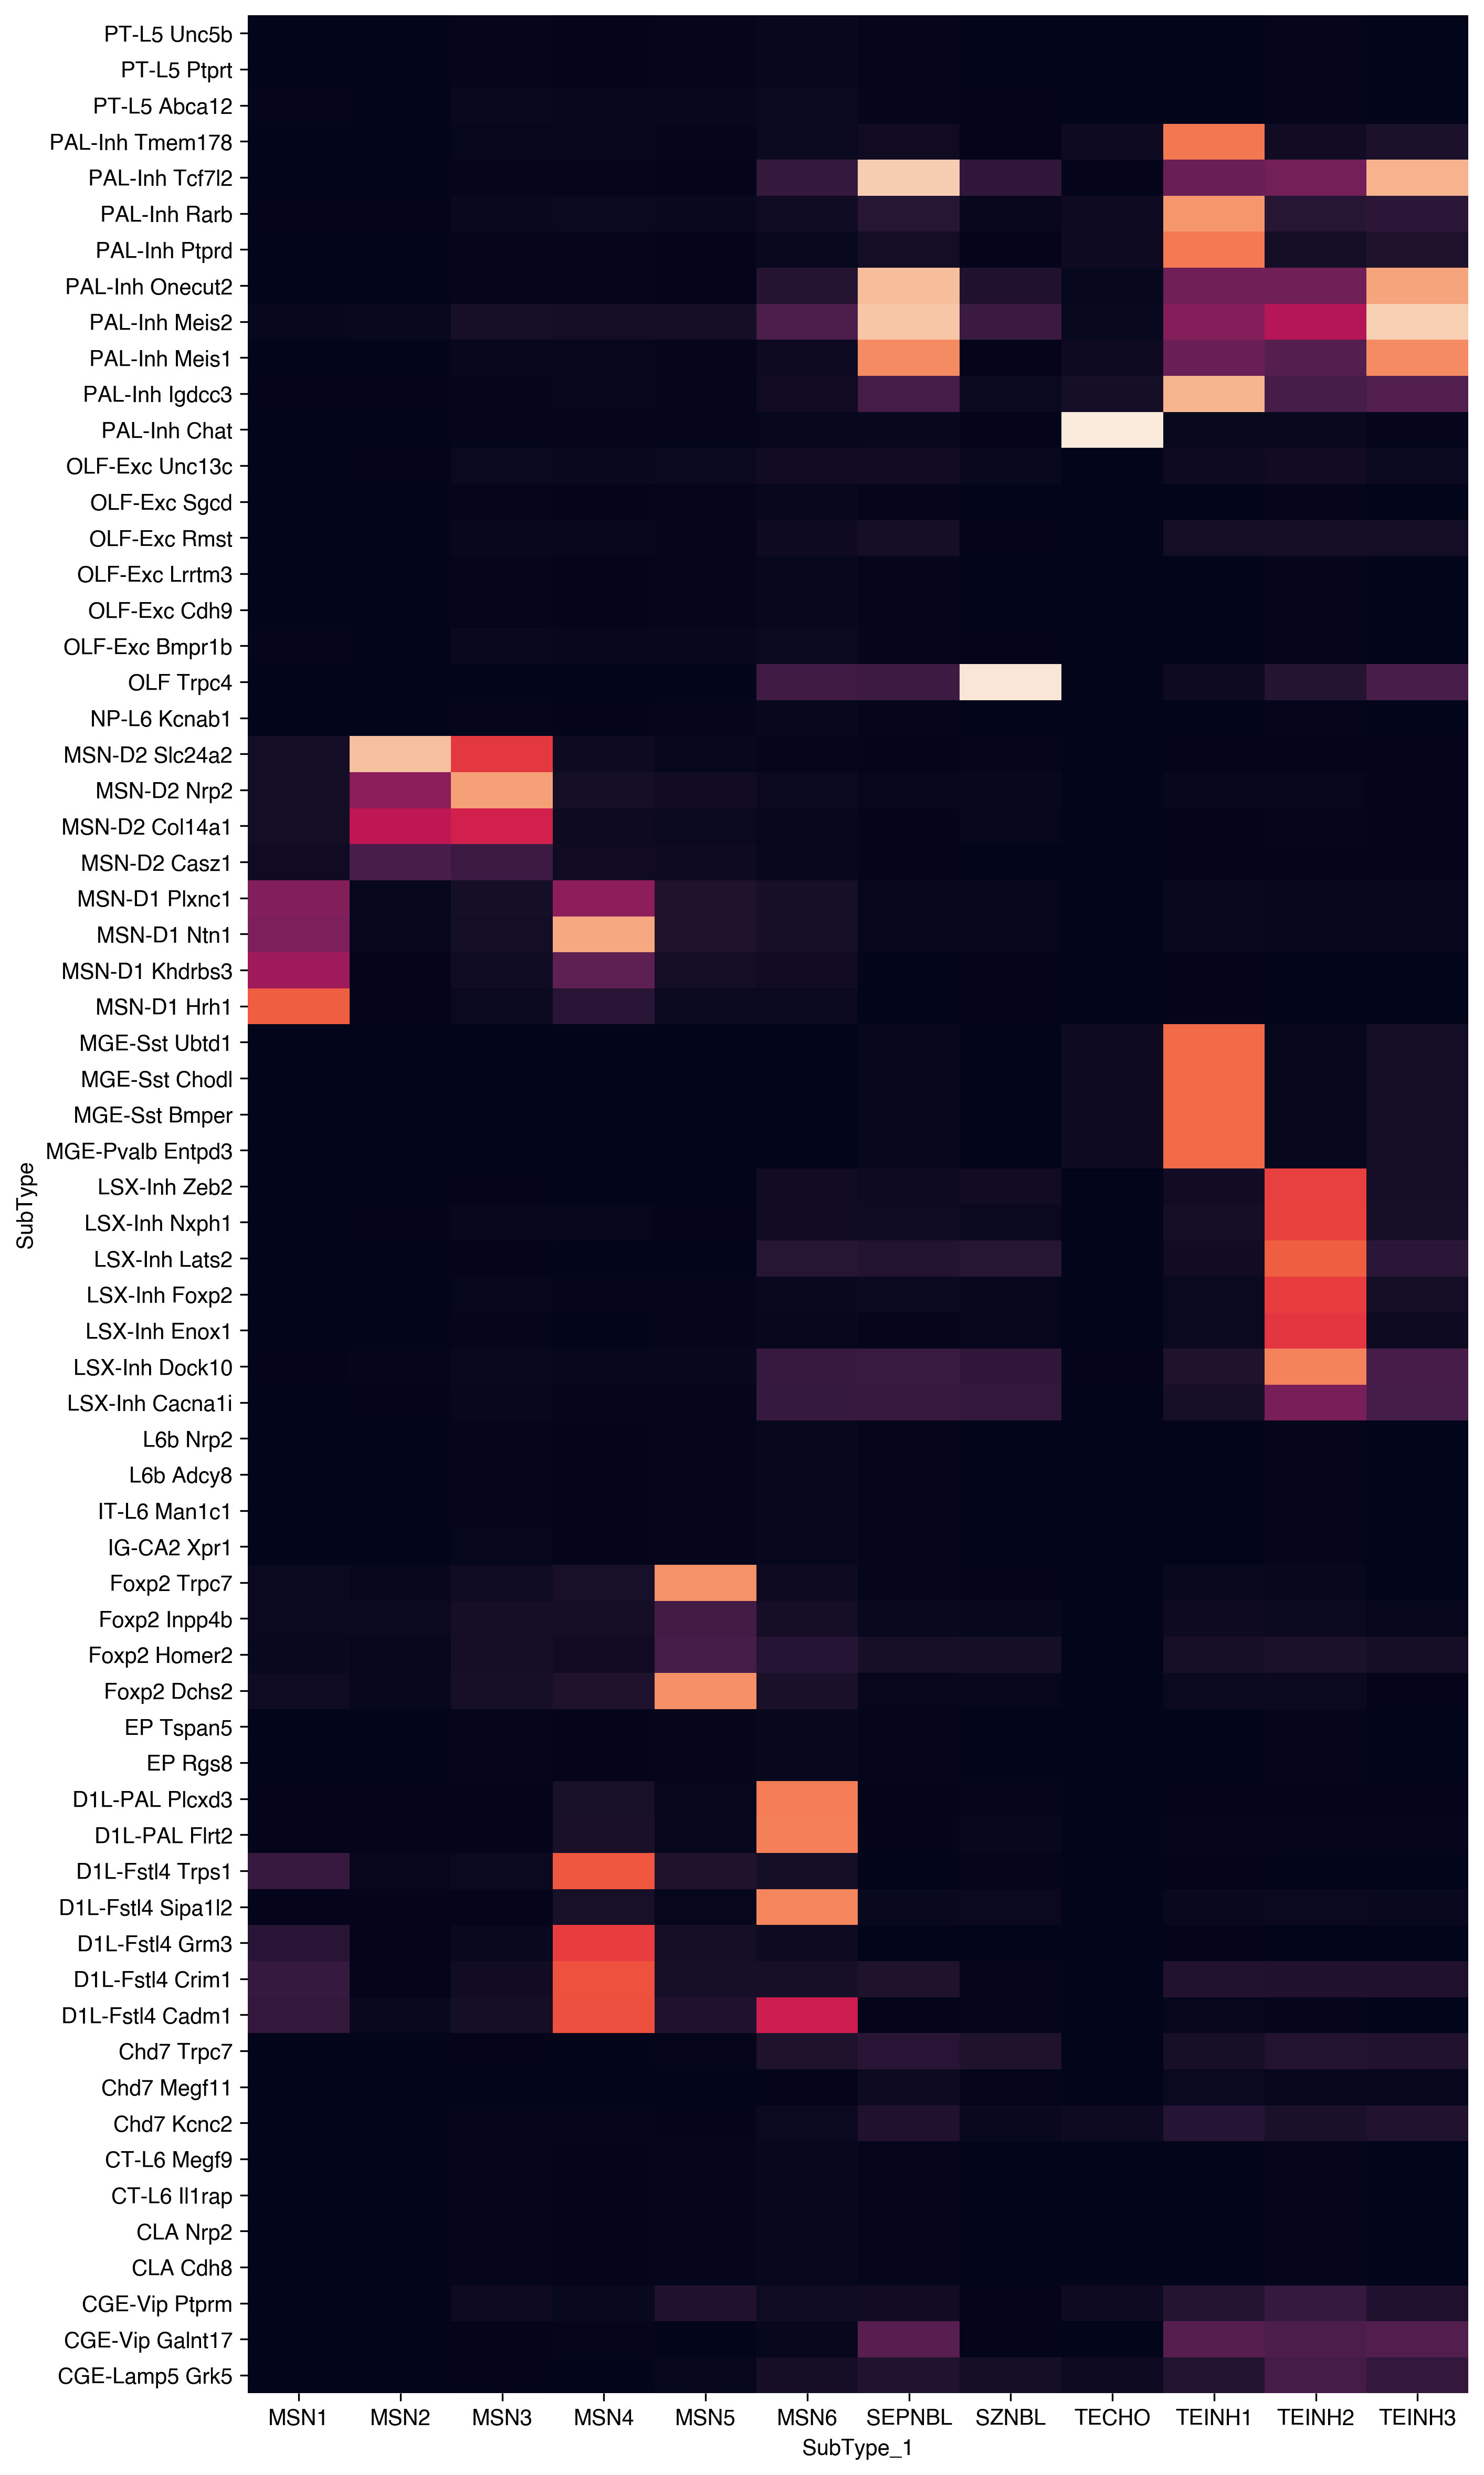

In [34]:
fig = plt.figure(figsize=(10, 20), dpi=300)

ax = sns.heatmap(cfm, cbar=None)
ax.set_ylim(0, cfm.shape[0])


## Save

In [31]:
adata.write_h5ad(output_dir / 'Integration.h5ad')

In [32]:
cell_tidy_data.to_msgpack(output_dir / 'Integration_cell_tidy_data.msg')
cell_tidy_data.head()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  """Entry point for launching an IPython kernel.


Modality leiden    umap_0    umap_1     pca_0     pca_1     tsne_0  \
3F_M_100        mC      2 -2.260578  5.219053  0.537209 -0.323435  21.303314   
3F_M_1000       mC      0 -8.586883 -0.972809  0.571694  0.389340  25.851627   
3F_M_1001       mC      9  5.286195  8.613996 -0.190805 -0.150032  -4.162850   
3F_M_1003       mC     12 -3.665113 -4.277300 -0.134055 -0.136484  -5.737744   
3F_M_1004       mC     10 -4.327795 -7.146789  0.222775 -0.047278  -7.832330   

              tsne_1  
3F_M_100   -2.953906  
3F_M_1000  30.988031  
3F_M_1001 -54.984750  
3F_M_1003  41.375757  
3F_M_1004  49.760203

In [33]:
mc_cell_tidy_data.to_msgpack(output_dir / 'mc_cell_tidy_data.with_integration_info.msg')
rna_cell_tidy_data.to_msgpack(output_dir / 'rna_cell_tidy_data.with_integration_info.msg')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  """Entry point for launching an IPython kernel.
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  
